In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import os
import seaborn as sn
import statsmodels.formula.api as smf
import warnings

warnings.simplefilter("ignore")
plt.style.use("ggplot")

# MARTINI riverine inputs

This notebook explores the standardised datasets generated in notebook 01, and uses them to estimate daily chemical concentrations for the parameters of interest.

## 1. Parameter combinations and aggregations

Some work is required initially to aggegate/integrate parameters from the various databases into what's needed for Martini. I'll start by summarising the available data in each country.

**Note:** The code below says nothing about the *amount* of data in each country - it's just the proportion of stations with *at least* one data point per parameter.

In [2]:
# Count stations in each country reporting each param type
df_list = []
for country in ["norway", "sweden", "denmark"]:
    csv_path = r"../data/tidy/martini_%s_chem_tidy.csv" % country
    wc_df = pd.read_csv(csv_path, encoding="utf-8")

    n_stns = len(wc_df["station_id"].unique())

    # Count sites with each parameter type
    wc_df = (
        wc_df.drop_duplicates(["station_id", "par_unit"])[["station_id", "par_unit"]]
        .groupby("par_unit")
        .count()
    )
    wc_df.columns = [country]

    # Convert from station counts to pct of stns in each country
    wc_df[country] = 100 * wc_df[country] / n_stns
    df_list.append(wc_df)

df = pd.concat(df_list, axis=1, sort=True)
df.fillna(0, inplace=True)
df = df.round(0)

df

,norway,sweden,denmark
DIP_µg/l,33.0,0.0,0.0
DOC_mg/l,50.0,0.0,16.0
DSIO2_µg/l,29.0,0.0,0.0
N-NH4_µg/l,100.0,100.0,100.0
N-NO2_µg/l,0.0,60.0,0.0
N-NO3_µg/l,100.0,0.0,0.0
N-ORG_µg/l,0.0,80.0,0.0
N-SNOX_µg/l,29.0,100.0,100.0
N-TOT_µg/l,100.0,100.0,100.0
P-TOT_µg/l,100.0,100.0,100.0


Note the following:

#### N and P

 * Stations in all three countries consistently measure `N-TOT` and `N-NH4`. All stations in Sweden and Denmark also report `N-SNOX`, which is what's required by the marine model. Norway usually only reports `N-NO3` but, since I expect `N-NO2` to be small in Norwegian rivers, it should be OK to use `N-NO3` directly instead. It looks as though there are a few sites in Norway with *both* `N-SNOX` and `N-NO3`, so this assumption can be checked - see below
 
 * If the above assumption holds, I can estimate `TON` as `(N-TOT - N-SNOX - N-NH4)`. Note that 80% of Swedish rivers also explicitly report `N-ORG`, so these estimates can be double-checked in Sweden
 
 * All countires measure `P-TOT`. Sweden and Norway also measure `TIP` (i.e. unfiltered, acid-hydrolysable P), so for these two countires I can estimate `TOP` as `(P-TOT - TIP)`
 
 * Unfortunately, Denmark only reports `SRP` (i.e. filtered orthophosphate), which is not equivalent to `TIP`. Transferring relationships derived in Sweden/Norway does not seem appropriate, as conditions in Denmark are very different. I think the best I can do is therefore to estimate `TOP` in Denmark as `(P-TOT - SRP)`, but **this will overestimate `TOP`**, since `SRP` ignores both the inorganic component of particulate P and the long-chain (polyphosphate) component of dissolved inorganic P (see figure below). **Check whether Phil is happy with this**
 
`TON` and `TOP` then need dividing into dissolved and particulate fractions, which is where things get a bit messy. The default approach is to use the regression equations specified by Phil in an e-mail received 02.05.2019. Alternatively:

 * For nitrogen, in Norway we have a small number of observations for `PON`. If I can match these to `TON` I might be able to derive a regression relationship for estimating `PON` elsewhere. `DON` can then be calculated as `(TON - PON)`. Note, however, that even if this works, the relationship will be based on a limited Norwegian dataset, which probably isn't applicable in e.g. Denmark
 
 * Phosphorous, as always, is a bit of a nightmare. This diagram illustrates the various fractions:
 
<p align="center">
  <img src="https://raw.githubusercontent.com/JamesSample/martini/master/images/p_sample_divisions.png" alt="P fractions" width="300" />
</p> 

Based on the discussion above, I can estimate `TOP` as `(P-TOT - TIP)` in Sweden and Norway (which is fine), and `(P-TOT - SRP)` in Denmark (which is dodgy, but i can't think of anything better at present). In Norway and Denmark, I have a small amount of data for `TDP`, so I could estimate the overall ratio of particluate to dissolved P in the sample as a whole and then assume this is also the ratio of `POP`:`DOP`. This assumption is unliekly to be correct, and it's not clear to me whether this approach will be better or worse than Phil's method, which first estimates `DON` and `PON` (from `DOC` and `POC`, respectively), and then estimates `POP` and `DOP` from `PON` and `DON` using Redfield ratios.

#### C

Norway and Sweden have reasonable `TOC` datasets, and in these countries, it is usual to assume `TOC ~ DOC`. Denmark does not report TOC or DOC (there are only a few measurements of `DOC` in the entire Danish dataset).

#### Si

There is very little data for `DSIO2`, but reasonable data for `SIO2` in Norway and Sweden. Denmark does not report silicate.

#### Suspended sediment

`STS` has good record in Norway and Denmark, but nothing in Sweden.

The main points above are explored in more detail below.

In [3]:
def long_to_wide(df, par_list):
    """ Convenience function for subsetting parameters and converting
        from 'long' to 'wide' format.
    """
    df2 = df.copy()

    # Get pars of interest
    df2 = df2.query("par_unit in @par_list")

    # Restructure
    df2.set_index(["station_id", "sample_date", "par_unit"], inplace=True)
    df2 = df2.unstack("par_unit")
    df2.columns = [i[1] for i in df2.columns.to_flat_index()]
    df2.reset_index(inplace=True)

    return df2

### 1.1. Ignoring nitrite in Norway

Norway usually reports `N-NO3` and not `N-SNOX`. Is this OK?

In [4]:
# Read Norway data
csv_path = r"../data/tidy/martini_norway_chem_tidy.csv"
nor_wc_df = pd.read_csv(csv_path, encoding="utf-8")
nor_wc_df.drop(["station_name", "lon", "lat"], axis=1, inplace=True)

# Restructure
wc_df = nor_wc_df.copy()
par_list = ["N-NO3_µg/l", "N-SNOX_µg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

print("The following stations have contemporaneous measurements of NO3 and (NO3+NO2):")
print(wc_df["station_id"].unique())
print("")
wc_df

The following stations have contemporaneous measurements of NO3 and (NO3+NO2):
[21]



,station_id,sample_date,N-NO3_µg/l,N-SNOX_µg/l
1748,21,2018-07-02,53.0,44.0
1749,21,2018-08-06,33.0,40.0
1750,21,2018-09-03,39.0,48.0
1751,21,2018-10-01,66.0,63.0


There are only 4 samples in the entire dataset with contemporaneous measurements, which isn't much to go on. However, in the data frame above, 2 of the four samples have `N-NO3 > N-SNOX`, which implies errors in the lab output are greater than the difference between these two parameters. **I will therefore assume `N-NO3 ~ N-SNOX` in Norway**.

In [5]:
# Reclass N-NO3 to N-SNOX in Norway
nor_wc_df["par_unit"].replace({"N-NO3_µg/l": "N-SNOX_µg/l"}, inplace=True)

# Average duplicates
nor_wc_df = (
    nor_wc_df.groupby(["station_id", "sample_date", "par_unit"]).mean().reset_index()
)
nor_wc_df.head()

,station_id,sample_date,par_unit,value
0,1,2000-01-01,N-NH4_µg/l,21.000000
1,1,2000-01-01,N-SNOX_µg/l,574.000000
2,1,2000-01-01,N-TOT_µg/l,936.000000
3,1,2000-01-01,SIO2_µg/l,40.068469
4,1,2000-01-01,STS_mg/l,2.140000


### 1.2. Checking TON in Sweden

A quick test comparing `(N-TOT - N-SNOX - N-NH4)` to `N-ORG` in Sweden. If I understand the MVM database correctly, `N-ORG` should be calculated like this anyway, so the values should be very close/identical. Nevertheless, it's a useful sense check.

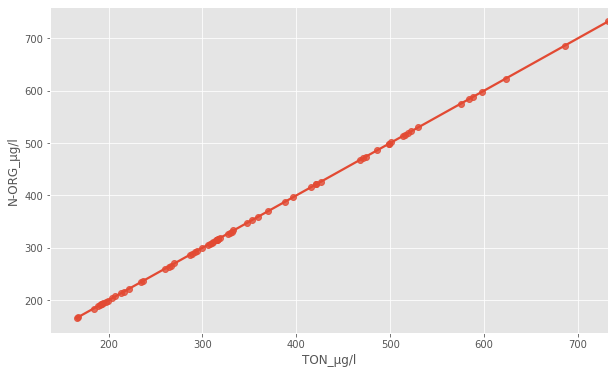

In [6]:
# Read Sweden data
csv_path = r"../data/tidy/martini_sweden_chem_tidy.csv"
swe_wc_df = pd.read_csv(csv_path, encoding="utf-8")
swe_wc_df.drop(["station_name", "lon", "lat"], axis=1, inplace=True)

# Restructure
wc_df = swe_wc_df.copy()
par_list = ["N-TOT_µg/l", "N-SNOX_µg/l", "N-NH4_µg/l", "N-ORG_µg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Calculate TON
wc_df["TON_µg/l"] = wc_df["N-TOT_µg/l"] - wc_df["N-SNOX_µg/l"] - wc_df["N-NH4_µg/l"]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sn.regplot(
    x="TON_µg/l", y="N-ORG_µg/l", data=wc_df, ax=ax,
)

### 1.3. Comparing PON and TON in Norway

Is there a consistent relationship between `PON` and `TON` in Norway?

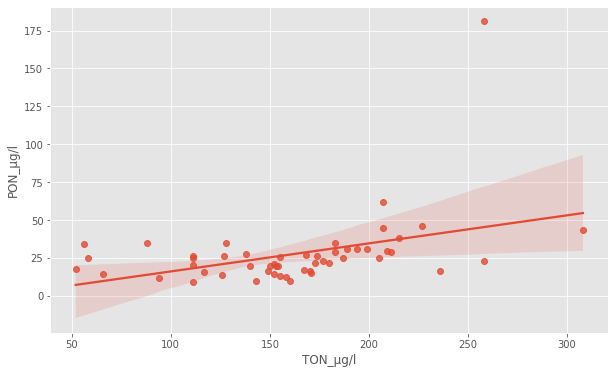

In [7]:
# Restructure
wc_df = nor_wc_df.copy()
par_list = ["N-TOT_µg/l", "N-SNOX_µg/l", "N-NH4_µg/l", "PON_µg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Calculate TON
wc_df["TON_µg/l"] = wc_df["N-TOT_µg/l"] - wc_df["N-SNOX_µg/l"] - wc_df["N-NH4_µg/l"]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sn.regplot(
    x="TON_µg/l", y="PON_µg/l", data=wc_df, ax=ax,
)

In [8]:
# OLS regression with intercept = 0
reg = smf.ols(formula='Q("PON_µg/l") ~ Q("TON_µg/l") - 1', data=wc_df).fit()

# Save slopes for later
pon_to_ton = reg.params.values[0]
don_to_ton = 1 - pon_to_ton

print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:          Q("PON_µg/l")   R-squared (uncentered):                   0.637
Model:                            OLS   Adj. R-squared (uncentered):              0.630
Method:                 Least Squares   F-statistic:                              89.65
Date:                Wed, 20 May 2020   Prob (F-statistic):                    8.02e-13
Time:                        07:35:43   Log-Likelihood:                         -234.13
No. Observations:                  52   AIC:                                      470.3
Df Residuals:                      51   BIC:                                      472.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

This isn't a great relationship, but it's not too bad: $R^2 = 63\%$ and $p \approx 0$. Based on this, I can estimate `PON` as 0.17 * `TON` (and `DON` is therefore 0.83 * `TON`).

**Is it appropriate to apply this relationship everywhere (especially in Denmark)?** Probably not, but a more relevant question is whether this approach is better than Phil's alternative, which is a power-law relationship with DOC based on rivers in the Arctic. I'm not sure which is better, but I'll continue with this for now.

### 1.4. Compare TDP and P-TOT in Denmark and Norway

**Note:** There is only 1 measurement of TDP from Denmark, so the results below are dominated by Norway.

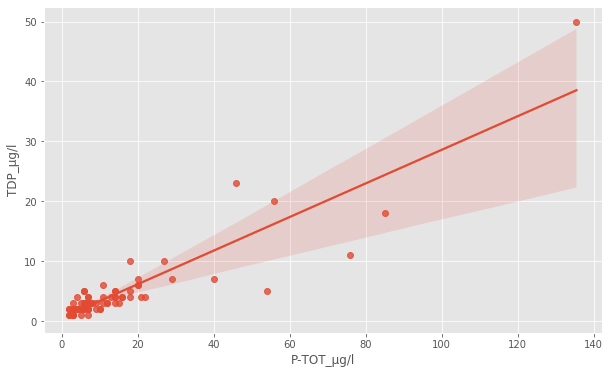

In [9]:
# Read Denmark data
csv_path = r"../data/tidy/martini_denmark_chem_tidy.csv"
den_wc_df = pd.read_csv(csv_path, encoding="utf-8")
den_wc_df.drop(["station_name", "lon", "lat"], axis=1, inplace=True)

# Combine Norway and Denmark
wc_df = pd.concat([nor_wc_df, den_wc_df], axis=0, sort=False)

# Restructure
par_list = ["P-TOT_µg/l", "TDP_µg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sn.regplot(
    x="P-TOT_µg/l", y="TDP_µg/l", data=wc_df, ax=ax,
)

In [10]:
# OLS regression with intercept = 0
reg = smf.ols(formula='Q("TDP_µg/l") ~ Q("P-TOT_µg/l") - 1', data=wc_df).fit()

# Save slopes for later
tdp_to_tp = reg.params.values[0]
tpp_to_tp = 1 - tdp_to_tp

print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:          Q("TDP_µg/l")   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                              492.5
Date:                Wed, 20 May 2020   Prob (F-statistic):                    1.08e-34
Time:                        07:35:44   Log-Likelihood:                         -189.33
No. Observations:                  76   AIC:                                      380.7
Df Residuals:                      75   BIC:                                      383.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

This regression has $R^2 = 87\%$ and $p \approx 0$. It's based almost entirely on Norwegian data, but the single measurement from Denmark (the point in the upper-right corner of the plot) is actually not too far from the overall trend. I can use this regression to divide total P into dissovled and particulate compomnents, but what I really want is to divide `TOP` into `DOP` and `POP`. The ratios between the different dissolved and particulate P fractions is unlikely to be constant but, nevertheless, **I will assume the ratio of `TDP`:`P-TOT` is the same as the ratio of `DOP`:`TOP`**. This is a pretty big assumption, but it's perhaps marginally better than Phil's original approach, which applied Redfield ratios to organic N  estimated from an earlier regression.

### 1.5. TOC and DOC

Most sites in Sweden and Norway report `TOC`. Norway also sometimes reports `DOC` and there are a few `DOC` measurements in the Danish dataset too. In Norway and Sweden, at least, `TOC` and `DOC` are very similar. I'll therefore simply use the "overall" regression below for estimating `DOC` from `TOC`.

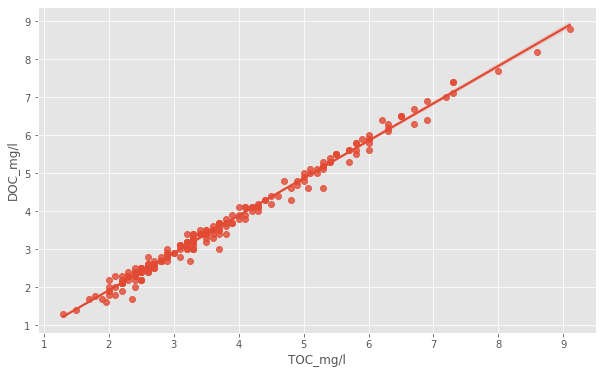

In [11]:
# Restructure
wc_df = nor_wc_df.copy()
par_list = ["TOC_mg/l", "DOC_mg/l"]
wc_df = long_to_wide(wc_df, par_list)
wc_df.dropna(how="any", inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sn.regplot(
    x="TOC_mg/l", y="DOC_mg/l", data=wc_df, ax=ax,
)

In [12]:
# OLS regression with intercept = 0
reg = smf.ols(formula='Q("DOC_mg/l") ~ Q("TOC_mg/l") - 1', data=wc_df).fit()

# Save slopes for later
doc_to_toc = reg.params.values[0]

print(reg.summary())

                                 OLS Regression Results                                
Dep. Variable:          Q("DOC_mg/l")   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.579e+05
Date:                Wed, 20 May 2020   Prob (F-statistic):                   1.19e-318
Time:                        07:35:44   Log-Likelihood:                          111.65
No. Observations:                 223   AIC:                                     -221.3
Df Residuals:                     222   BIC:                                     -217.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## 2. Estimating daily concentrations

### 2.1. Combine all data

In [13]:
# Combine chem
nor_wc_df["station_id"] = "vm_" + nor_wc_df["station_id"].apply(lambda x: "%03d" % x)
swe_wc_df["station_id"] = "mvm_" + swe_wc_df["station_id"].apply(lambda x: "%05d" % x)
den_wc_df["station_id"] = "oda_" + den_wc_df["station_id"].apply(lambda x: "%s" % x)
wc_df = pd.concat([nor_wc_df, swe_wc_df, den_wc_df], axis=0, sort=False)
wc_df = wc_df[["station_id", "sample_date", "par_unit", "value"]]

# Read q
csv_path = r"../data/tidy/martini_all_daily_flows_tidy.csv"
q_df = pd.read_csv(csv_path, encoding="utf-8")
q_df.rename({"flow_m3/s": "value", "date": "sample_date"}, axis=1, inplace=True)
q_df["par_unit"] = "flow_m3/s"

# Combine all, filter, restructure
df = pd.concat([wc_df, q_df], axis=0, sort=False)
par_list = [
    "N-NH4_µg/l",
    "N-SNOX_µg/l",
    "N-TOT_µg/l",
    "SIO2_µg/l",
    "STS_mg/l",
    "TIP_µg/l",
    "TOC_mg/l",
    "P-TOT_µg/l",
    "DOC_mg/l",
    "TDP_µg/l",
    "SRP_µg/l",
    "flow_m3/s",
]
df = long_to_wide(df, par_list)
df.sort_values(["station_id", "sample_date"], inplace=True)

# Some flows are negative. Set to zero
df["flow_m3/s"][df["flow_m3/s"] < 0] = 0

# Just 2000 to 2018
df = df.query('(sample_date >= "2000-01-01") and (sample_date <= "2018-12-31")')

# Save
out_csv = r"../data/tidy/martini_all_river_data.csv"
df.to_csv(out_csv, index=False, encoding="utf-8")

df.head()

,station_id,sample_date,DOC_mg/l,N-NH4_µg/l,N-SNOX_µg/l,N-TOT_µg/l,P-TOT_µg/l,SIO2_µg/l,SRP_µg/l,STS_mg/l,TDP_µg/l,TIP_µg/l,TOC_mg/l,flow_m3/s
365,mvm_00031,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8
366,mvm_00031,2000-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.1
367,mvm_00031,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.4
368,mvm_00031,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
369,mvm_00031,2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.1


### 2.2. Regression analysis

In [14]:
# Min number of data points to attempt regression
min_n_pts = 20

# Pars of interest
chem_pars = [
    "N-NH4_µg/l",
    "N-SNOX_µg/l",
    "N-TOT_µg/l",
    "SIO2_µg/l",
    "STS_mg/l",
    "TIP_µg/l",
    "TOC_mg/l",
    "P-TOT_µg/l",
    "SRP_µg/l",
]

# Containers for data
df_list = []
reg_dict = {
    "station_id": [],
    "parameter": [],
    "slope": [],
    "intcpt": [],
    "r2_pct": [],
    "p_val": [],
}

# Loop over stations
for stn_id in df["station_id"].unique():
    stn_df = df.query("station_id == @stn_id").copy()
    del stn_df["TDP_µg/l"]

    # Loop overs pars of interest
    for par in chem_pars:
        # Set values equal to exactly zero to NaN
        stn_df[par][stn_df[par] == 0] = np.nan
        par_df = stn_df[[par, "flow_m3/s"]].dropna(how="any")

        if len(par_df) > min_n_pts:
            # Attempt log-log regression with flow
            par_df2 = np.log10(par_df)
            par_df2.columns = ["log(%s)" % i for i in par_df2.columns]
            par_df = par_df.join(par_df2)

            # OLS regression
            res = smf.ols(
                formula='Q("log(%s)") ~ Q("log(flow_m3/s)")' % par, data=par_df
            ).fit()

            # Add summary stas to output
            reg_dict["station_id"].append(stn_id)
            reg_dict["parameter"].append(par)
            reg_dict["slope"].append(res.params[1])
            reg_dict["intcpt"].append(res.params[0])
            reg_dict["r2_pct"].append(res.rsquared * 100)
            reg_dict["p_val"].append(res.pvalues[1])

            # Update stn_df with values from regression
            concs = (10 ** res.params[0]) * (stn_df["flow_m3/s"] ** res.params[1])

            # Back-transform
            alpha = np.exp(2.651 * ((res.resid.values) ** 2).mean())
            concs = alpha * concs

            # Update series
            stn_df[par] = concs  # df[par].fillna(concs)

            # Plot diagnotsics
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            sn.regplot(
                x="log(flow_m3/s)", y="log(%s)" % par, data=par_df, ax=axes[0],
            )
            axes[0].set_xlabel("log[Flow (m3/s)]")
            axes[0].set_ylabel("log(%s)" % par)
            axes[0].set_title("Regression")

            axes[1].plot(res.model.exog[:, 1], res.resid, "ro")
            axes[1].set_xlabel("log[Flow (m3/s)]")
            axes[1].set_ylabel("Residual")
            axes[1].set_title("Residuals")

            sn.distplot(res.resid.values, ax=axes[2])
            axes[2].set_xlabel("Residual")
            axes[2].set_title("Residual histogram")

            plt.suptitle("%s at station %s" % (par.split("_")[0], stn_id), fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            # Save png
            png_path = r"../plots/flow_conc_reg/%s_%s.png" % (stn_id, par.split("_")[0])
            plt.savefig(png_path, dpi=300)
            plt.close()

    # Truncate stn_df
    stn_df = stn_df.query(
        '(sample_date >= "2015-01-01") and (sample_date <= "2017-12-31")'
    )

    # Calculate derived parameters
    # TON, DON, PON
    stn_df["TON_µg/l"] = (
        stn_df["N-TOT_µg/l"] - stn_df["N-SNOX_µg/l"] - stn_df["N-NH4_µg/l"]
    )
    stn_df["TON_µg/l"][stn_df["TON_µg/l"] < 0] = 0
    stn_df["DON_µg/l"] = don_to_ton * stn_df["TON_µg/l"]
    stn_df["PON_µg/l"] = pon_to_ton * stn_df["TON_µg/l"]

    # TOP, DOP, POP
    if stn_id[:3] == "oda":
        # Use SRP in Denmark
        stn_df["TOP_µg/l"] = stn_df["P-TOT_µg/l"] - stn_df["SRP_µg/l"]
    else:
        # Use TIP
        stn_df["TOP_µg/l"] = stn_df["P-TOT_µg/l"] - stn_df["TIP_µg/l"]

    stn_df["TOP_µg/l"][stn_df["TOP_µg/l"] < 0] = 0
    stn_df["DOP_µg/l"] = tdp_to_tp * stn_df["TOP_µg/l"]
    stn_df["POP_µg/l"] = tpp_to_tp * stn_df["TOP_µg/l"]

    # DOC
    stn_df["DOC_mg/l"] = doc_to_toc * stn_df["TOC_mg/l"]

    # Add to output
    df_list.append(stn_df)

    # Plot daily series
    plot_df = stn_df.drop(["station_id"], axis=1)
    plot_df.set_index("sample_date", inplace=True)
    col_order = [
        "flow_m3/s",
        "N-TOT_µg/l",
        "N-SNOX_µg/l",
        "N-NH4_µg/l",
        "TON_µg/l",
        "DON_µg/l",
        "PON_µg/l",
        "P-TOT_µg/l",
        "TIP_µg/l",
        "SRP_µg/l",
        "TOP_µg/l",
        "DOP_µg/l",
        "POP_µg/l",
        "TOC_mg/l",
        "DOC_mg/l",
        "STS_mg/l",
        "SIO2_µg/l",
    ]
    plot_df = plot_df[col_order]
    plot_df.plot(
        subplots=True,
        layout=(6, 3),
        figsize=(15, 20),
        legend=False,
        title=list(plot_df.columns),
    )
    plt.tight_layout()

    # Save png
    png_path = r"../plots/daily_series/%s.png" % stn_id
    plt.savefig(png_path, dpi=200)
    plt.close()

# Combine interpolated results for all stations
interp_df = pd.concat(df_list, axis=0, sort=False)
interp_df.sort_values(["station_id", "sample_date"], inplace=True)

# Regression summary
reg_df = pd.DataFrame(reg_dict)

# Save
interp_csv = r"../data/tidy/martini_daily_concs_from_q.csv"
interp_df.to_csv(interp_csv, index=False, encoding="utf-8")

# Save
reg_csv = r"../data/tidy/martini_c-q_regression_summary.csv"
reg_df.to_csv(reg_csv, index=False, encoding="utf-8")